# Contents and goals
This kernel shows how to:

 - retreave the data;
 - preprocess the data (transforming One-Hot Encoding into Label Encoding);
 - visualise of the data in 1, 2 and 3 dimentions;
 - engineer new features inspired by the visualisation done in the previous step;
 - use proportion of target classes in the test data in the training and model evaluation to improve consistency between local CV and LB;
 - build various models on the train/test spit of the data and evaluate their performance. Hyper-parameters of the models are optimised in a dedicated kernel:  https://www.kaggle.com/mlisovyi/hyper-parameter-optimisation;
 - build voting classifiers and evaluated their performance in a nested cross-validation (CV);
 - prepare submissions
 
 Note, that the proportion of the different classes in test is: `0.37053 : 0.49681 : 0.05936 : 0.00103 : 0.01295 : 0.02687 : 0.03242`, as is discussed in https://www.kaggle.com/mlisovyi/class-fractions-in-the-test

# General configuration and imports

In [1]:
# controlls the number of entries to be read in by the kernel
# can speed up processing, is a small number if set here
max_events = None

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # needed for 3D scatter plots
%matplotlib inline 
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")

#PATH='../input/'
PATH='/home/mlisovyi/.kaggle/competitions/forest-cover-type-kernels-only/'

import os
print(os.listdir(PATH))

['sample_submission.csv.zip', 'train.csv', 'sample_submission.csv', 'test.csv', 'train.csv.zip', 'test.csv.zip']


# Access the data

In [5]:
train = pd.read_csv('{}/train.csv'.format(PATH), nrows=max_events)
test  = pd.read_csv('{}/test.csv'.format(PATH), nrows=max_events)

y = train['Cover_Type']
train.drop('Cover_Type', axis=1, inplace=True)

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [6]:
print('Train shape: {}'.format(train.shape))
print('Test  shape: {}'.format(test.shape))

Train shape: (15120, 54)
Test  shape: (565892, 54)


In [7]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Columns: 54 entries, Elevation to Soil_Type40
dtypes: int64(54)
memory usage: 6.2 MB


Is the sample imbalanced?

In [8]:
y.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

Note, that the proportion of the different classes in test is: `0.37053 : 0.49681 : 0.05936 : 0.00103 : 0.01295 : 0.02687 : 0.03242`, as is discussed in https://www.kaggle.com/mlisovyi/class-fractions-in-the-test

## OHE into LE

Helper function to transfer One-Hot Encoding (OHE) into a Label Encoding (LE). It was taken from https://www.kaggle.com/mlisovyi/lighgbm-hyperoptimisation-with-f1-macro

The reason to convert OHE into LE is that we plan to use a tree-based model and such models are dealing well with simple interger-label encoding. Note, that this way we introduce an ordering between categories, which is not there in reality, but in practice in most use cases GBMs handle it well anyway.

In [9]:
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['Soil_Type', 'Wilderness_Area']:
        cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_df[s_ + '_LE'] = tmp_df[cols_s_].idxmax(axis=1).str.replace(s_,'').astype(np.uint16)
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df



def train_test_apply_func(train_, test_, func_):
    xx = pd.concat([train_, test_])
    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :]

    del xx, xx_func
    return train_, test_

In [10]:
train_x, test_x = train_test_apply_func(train, test, convert_OHE2LE)

One little caveat: looking through the OHE, `Soil_Type 7, 15`, are present in the test, but not in the training data

The head of the training dataset

In [11]:
train_x.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type_LE,Wilderness_Area_LE
0,2596,51,3,258,0,510,221,232,148,6279,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,29,1


## Plot distributions of individual features

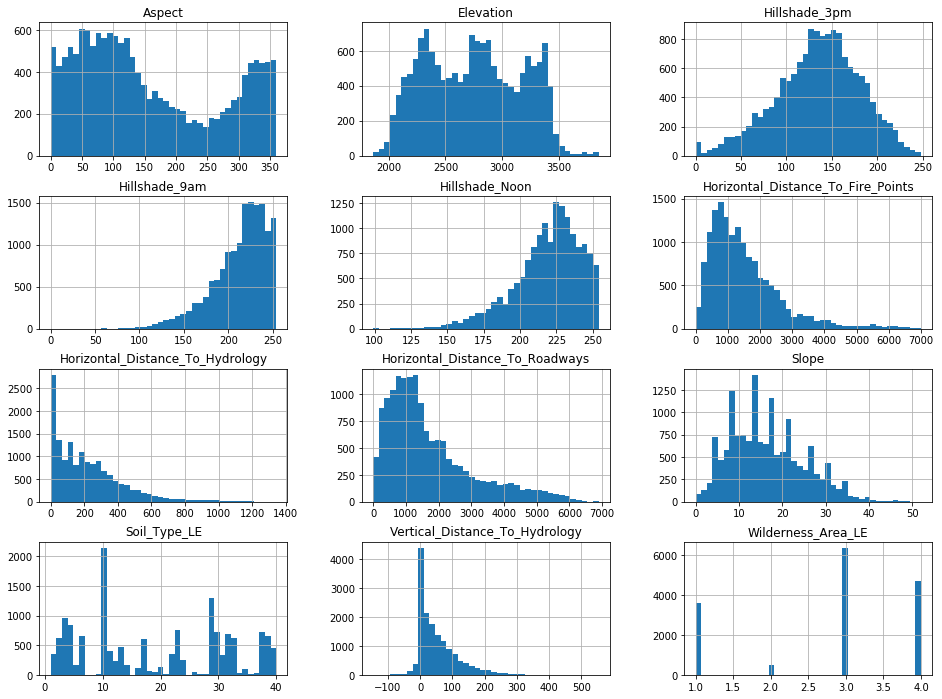

In [12]:
train_x.hist(figsize=(16,12),bins=40)
plt.show()

Note the spike at `Hillshade_3pm==0` that was originally pointed out by @aguschin in https://github.com/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb

### How do feature distributions look in the test sample?

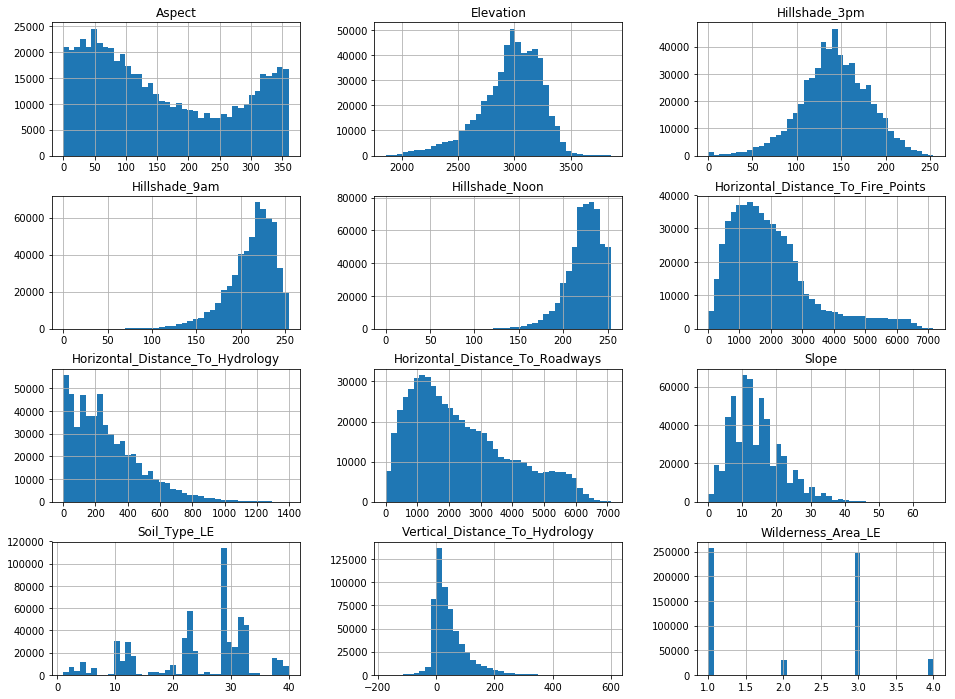

In [13]:
test_x.hist(figsize=(16,12), bins=40)
plt.show()

Most distributions look similar, but note that **`Elevation` profile is totally different between train and test samples**. There are also minor differences in `Soil_Type`. 

The little spike at `Hillshade_3pm==0` is also present in the test sample.

## Can we reproduce the test distributions? 
How will the training dataset look like if we apply the mixing from the test sample?

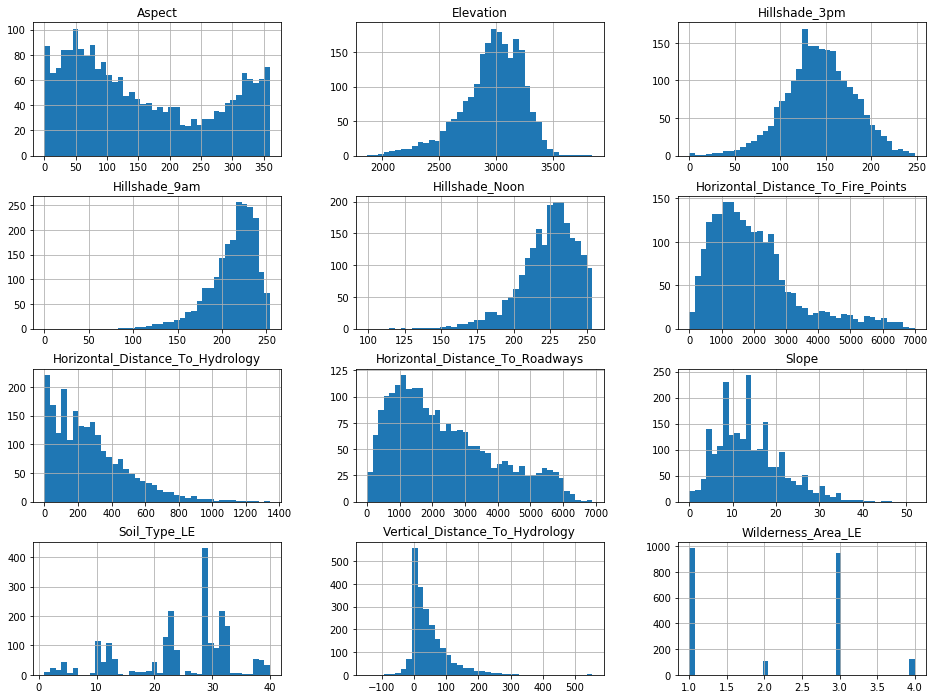

In [12]:
test_weight_orig_map = {1: 0.37053, 2: 0.49681, 3: 0.05936, 4:0.00103, 5: 0.01295, 6: 0.02687, 7: 0.03242}
train_x.hist(figsize=(16,12),bins=40, weights=y.map(test_weight_orig_map))
plt.show()

Yahoo! **Application of weights allows to reproduce the distributions of variables in the submission sample very closely.**

## Aspect shape
Let's parametrise `Aspect` feature, which looks like a cosine function. **We will not use it, but it is fun :)**

In [ ]:
# Parametrise aspect function using a simle fit closely following solution from https://stackoverflow.com/a/16716964/9640384
y_, x_, _ = plt.hist(test_x['Aspect'], bins=30)

t = x_[:-1] + np.diff(x_)/2
data = y_

from scipy.optimize import leastsq

#def func_aspect(x)

guess_mean = np.mean(y_)
guess_std = np.std(y_)
guess_phase = 0
guess_freq = np.pi/360

optimize_func = lambda x: (x[0]*np.cos(x[1]*t+x[2]) + x[3] - data)/np.sqrt(data)
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_std, guess_freq, guess_phase, guess_mean])[0]

fine_t = np.arange(0,max(t),0.1)
data_fit = est_amp*np.cos(est_freq*fine_t+est_phase)+est_mean
data_first_guess = guess_std*np.cos(guess_freq*fine_t+guess_phase) + guess_mean

plt.plot(fine_t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting')
plt.xlabel('Aspect')
plt.legend()
plt.show()

print('Fit parameters: \n Amplitude = {:.1f}\n Frequency = {:.4f}\n Phase shift = {:.4f}\n Pedestal = {:.1f}'.format(est_amp, est_freq, est_phase, est_mean))

# How to impute Hillside_3pm?
Let's follow the proposal by @jmcminis in [this post](https://www.kaggle.com/c/forest-cover-type-prediction/discussion/10693#62731):

In [ ]:
def plot3D_hillshade(X_, y_, x_str='Aspect', y_str='Slope', z_str='Hillshade_3pm', figsize=(17,8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')

    p = ax.scatter(X_[x_str], X_[y_str], X_[z_str], c=(y_ if y_ is not None else X_[z_str]))
    _ = ax.set_xlabel(x_str)
    _ = ax.set_ylabel(y_str)
    _ = ax.set_zlabel(z_str)
    plt.colorbar(p, ax=ax)

Train: sample

In [ ]:
plot3D_hillshade(train_x, None, z_str='Hillshade_3pm')
_ = plt.title('TRAIN sample')

Test sample:

In [ ]:
plot3D_hillshade(test_x, None, z_str='Hillshade_3pm')
_ = plt.title('TEST sample')

We see that the location of the `Hillshade_3pm==0` events is the same between train and test samples. The best way would be to parametrise `Hillshade_3pm` as a function of `Aspect` and `Slope`. But this requires parametric form, that is not trivial. 

The simpler solution is to **run KNN algorithm and assign the `Hillshade_3pm` values for these tricky events  using `Aspect` and `Slope` as inputs**. Note, that one would want to do it on the data subset used for training only and predict with such learned model for the test/validation subset as well as for the submission dataset. The same applies for a CV loop

The following suits only as an illustration and proof-of-consept

In [ ]:
# define a grid for visualisation
x_aspect = np.linspace(0, 360, 360)
x_slope  = np.linspace(0, 60, 60)
grid_aspect, grid_slope = np.meshgrid(x_aspect, x_slope)
grid_aspect = grid_aspect.ravel()
grid_slope = grid_slope.ravel()

# a simplified version of `plot3D_hillshade` function
def plot3D_basic(x, y, z, figsize=(17,8)):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    p = ax.scatter(x, y, z, c=z)
    plt.colorbar(p, ax=ax)

# select the training data with non-zero `Hillshade_3pm`
train_nonzero_3pm = train_x.query('Hillshade_3pm >= 1')
    
# train a KNN model on the full train set for illustration purpose only
from sklearn.neighbors import KNeighborsRegressor
k=100
knn = KNeighborsRegressor(n_neighbors=k).fit(train_nonzero_3pm[['Aspect', 'Slope']], 
                                             train_nonzero_3pm['Hillshade_3pm'])
#predict on the predefined grid for plotting
preds_3pm = knn.predict(pd.DataFrame({'Aspect': grid_aspect,
                                      'Slope':  grid_slope}))
#Do the final plot
plot3D_basic(grid_aspect, grid_slope, preds_3pm)
_ = plt.title('KNN: {}'.format(k))

# How do other Hillside_ variables look like?

In [ ]:
plot3D_hillshade(train_x, None, z_str='Hillshade_Noon')

In [ ]:
plot3D_hillshade(train_x, None, z_str='Hillshade_9am')

In [ ]:
plot3D_hillshade(train_x, None, x_str='Hillshade_9am', y_str='Hillshade_Noon', z_str='Hillshade_3pm')

## Interactive 3D plots
At the moment `cufflinks` do not support `plotly>=3.0.0` (see [issue #119 on github](https://github.com/santosjorge/cufflinks/issues/119)) and kaggle docker image has `plotly==3.1.1`. So cufflinks are useless.  

Writing directly in plotly is combersome, so this section is commented out for the time being

In [ ]:
# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode(connected=True)
# import cufflinks as cf

In [ ]:
# train_x.iplot(kind='scatter3D', x='Aspect', y='Slope', z='Hillshade_3pm', bgcolor='yellowgreen')

In [ ]:
#plotly.__version__

# EDA
The scatter-plot implementation and visualisation come from https://github.com/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb. The plotting function will highlight different target classes with different colours.

In [ ]:
def plotc(c1, c2, labels, size=10, doGrid=True):
    fig = plt.figure(figsize=(16,8))

    plt.scatter(c1, c2, c=labels.values, s=size)
    plt.colorbar()
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    if doGrid:
        plt.grid(True)

In [ ]:
plotc(train_x['Vertical_Distance_To_Hydrology'],  train_x['Elevation'], y, size=10)

These inclined structures indicate a linear dependence between the two variables. However, such linear dependence is hard to capture with decision trees, so one typicaly introduces linear combinations of such features

In [ ]:
plotc(train_x['Vertical_Distance_To_Hydrology'], train_x['Elevation']-train_x['Vertical_Distance_To_Hydrology'], y, size=10)

With such new feature it will be much easier for a decision tree to separate between classes with cuts on the X axis. 
This shows the importance of the difference variables

In [ ]:
plotc(train_x['Horizontal_Distance_To_Hydrology'], train_x['Elevation'],   y)

Here there is also a linear dependence, but it is weaker than what we saw before. We use the linear combination developed by @aguschin:

In [ ]:
plotc(train_x['Horizontal_Distance_To_Hydrology'], train_x['Elevation']- train_x['Horizontal_Distance_To_Hydrology']*0.2,  y)

# Let's do actual Feature engineering

In [14]:
def preprocess(df_):
    #df_.drop('Elevation', axis=1, inplace=True)
    df_['fe_E_Min_02HDtH'] = df_['Elevation']- df_['Horizontal_Distance_To_Hydrology']*0.2
    df_['fe_Distance_To_Hydrology'] = np.sqrt(df_['Horizontal_Distance_To_Hydrology']**2 + 
                                              df_['Vertical_Distance_To_Hydrology']**2)
    
    feats_sub = [('E_Min_VDtH', 'Elevation', 'Vertical_Distance_To_Hydrology'),
                 ('HD_Hydrology_Min_Roadways', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways'),
                 ('HD_Hydrology_Min_Fire', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points'),
                 ('Hillshade_9am_Min_Noon', 'Hillshade_9am', 'Hillshade_Noon'),
                 ('Hillshade_Noon_Min_3pm', 'Hillshade_Noon', 'Hillshade_3pm'),
                 ('Hillshade_9am_Min_3pm', 'Hillshade_9am', 'Hillshade_3pm')
                ]
    feats_add = [('Elevation_Add_VDtH', 'Elevation', 'Vertical_Distance_To_Hydrology')
                ]
    
    for f_new, f1, f2 in feats_sub:
        df_['fe_' + f_new] = df_[f1] - df_[f2]
    for f_new, f1, f2 in feats_add:
        df_['fe_' + f_new] = df_[f1] + df_[f2]
        
    # A few composite variables
    df_['fe_Hillshade_Ratio1'] = (df_['fe_Hillshade_9am_Min_Noon'] / df_['fe_Hillshade_Noon_Min_3pm']).clip(lower=-5, upper=2)
    df_['fe_Hillshade_Ratio2'] = (df_['fe_Hillshade_9am_Min_3pm']  / df_['Hillshade_Noon']).clip(lower=-2, upper=2)
        
    # The feature is advertised in https://douglas-fraser.com/forest_cover_management.pdf
    df_['fe_Shade9_Mul_VDtH'] = df_['Hillshade_9am'] * df_['Vertical_Distance_To_Hydrology']
    
    # Features inherited from https://www.kaggle.com/leannelong3/r-random-forest
    df_['Elevation_bins50'] = np.floor_divide(df_['Elevation'], 50)
    df_['fe_Horizontal_Distance_To_Roadways_Log'] = np.log1p(df_['Horizontal_Distance_To_Roadways'])

    # this mapping comes from https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info
    climatic_zone = {}
    geologic_zone = {}
    for i in range(1,41):
        if i <= 6:
            climatic_zone[i] = 2
            geologic_zone[i] = 7
        elif i <= 8:
            climatic_zone[i] = 3
            geologic_zone[i] = 5
        elif i == 9:
            climatic_zone[i] = 4
            geologic_zone[i] = 2
        elif i <= 13:
            climatic_zone[i] = 4
            geologic_zone[i] = 7
        elif i <= 15:
            climatic_zone[i] = 5
            geologic_zone[i] = 1
        elif i <= 17:
            climatic_zone[i] = 6
            geologic_zone[i] = 1
        elif i == 18:
            climatic_zone[i] = 6
            geologic_zone[i] = 7
        elif i <= 21:
            climatic_zone[i] = 7
            geologic_zone[i] = 1
        elif i <= 23:
            climatic_zone[i] = 7
            geologic_zone[i] = 2
        elif i <= 34:
            climatic_zone[i] = 7
            geologic_zone[i] = 7
        else:
            climatic_zone[i] = 8
            geologic_zone[i] = 7
            
    df_['Climatic_zone_LE'] = df_['Soil_Type_LE'].map(climatic_zone).astype(np.uint8)
    df_['Geologic_zone_LE'] = df_['Soil_Type_LE'].map(geologic_zone).astype(np.uint8)
    
    for c in df_.columns:
        if c.startswith('fe_'):
            df_[c] = df_[c].astype(np.float32)
    return df_

In [15]:
train_x = preprocess(train_x)
test_x = preprocess(test_x)

In [16]:
# test_x.hist(figsize=(16,12),bins=40)
# plt.show()

In [17]:
# train_x.hist(figsize=(16,12),bins=40)
# plt.show()

# To be continued...

# Optimise various classifiers

In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from  sklearn.linear_model import LogisticRegression
import lightgbm as lgb

Some of the models (LightGBM in particular) expect the labels to start from 0

In [19]:
y = y-1

The train/test split is used in simple model training

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_x, y, test_size=0.15, random_state=315, stratify=None)

These are the weights that correspond to the test/submission class mixture. using these will allow to adjust importance of mistakes on different classes

In [21]:
test_weight_map = {0: 0.37053, 1: 0.49681, 2: 0.05936, 3:0.00103, 4: 0.01295, 5: 0.02687,6 : 0.03242}

Various machine-learning models to be used to model the data

In [72]:
def learning_rate_decay_power_0995(current_iter):
    base_learning_rate = 0.15
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-2 else 1e-2

clf_inputs = {'rf': (RandomForestClassifier(n_estimators=200, max_depth=1, random_state=314, n_jobs=4),
               {'max_depth': 30}, 
               {}),
        'rf_test': (RandomForestClassifier(n_estimators=200, max_depth=1, random_state=314, n_jobs=4,
                                           class_weight=test_weight_map),
               {'max_depth': 30}, 
               {}),
        'xt200': (ExtraTreesClassifier(n_estimators=400, criterion='entropy', max_depth=1, max_features='auto',random_state=314, n_jobs=4),
               {'max_depth': 25},
               {}),
        'xt200_test': (ExtraTreesClassifier(n_estimators=400, criterion='entropy', max_depth=1, max_features='auto',random_state=314, n_jobs=4,
                                            class_weight=test_weight_map),
               {'max_depth': 25},
               {}),
        'lgbm': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, 
                                 random_state=314, silent=True, metric='None', 
                                 n_jobs=4, n_estimators=5000, learning_rate=0.1), 
                 {'loss': 'multiclass', 'colsample_bytree': 0.75, 'min_child_weight': 1, 'num_leaves': 20, 'subsample': 0.75}, 
                 {'eval_set': [(X_train, y_train), (X_test, y_test)], 
                  'eval_names': ['train', 'early_stop'],
                  'eval_metric': 'multi_error', 'verbose':500, 'early_stopping_rounds':100, 
                  'callbacks':[lgb.reset_parameter(learning_rate=learning_rate_decay_power_0995)]}
                ),
        'lgbm_test': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, 
                                 random_state=314, silent=True, metric='None', 
                                 n_jobs=4, n_estimators=5000, learning_rate=0.1,
                                        class_weight=test_weight_map), 
                 {'loss': 'multiclass', 'colsample_bytree': 0.75, 'min_child_weight': 1, 'num_leaves': 20, 'subsample': 0.75}, 
                 {'eval_set': [(X_train, y_train), (X_test, y_test)], 
                  'eval_names': ['train', 'early_stop'],
                  'eval_class_weight': [{}, test_weight_map],
                  'eval_metric': 'multi_error', 'verbose':500, 'early_stopping_rounds':100, 
                  'callbacks':[lgb.reset_parameter(learning_rate=learning_rate_decay_power_0995)]}
                )
       }

In [ ]:
clfs = {}
for name, (clf, clf_pars, fit_pars) in clf_inputs.items():
    print('--------------- {} -----------'.format(name))
    clf.set_params(**clf_pars)
    clf = clf.fit(X_train, y_train, **fit_pars)
    acc_pars={}
    print('{}: with/without weight  train = {:.4f}/{:.4f}, test = {:.4f}/{:.4f}'.format(name,
        accuracy_score(y_train, clf.predict(X_train), sample_weight=y_train.map(test_weight_map)),
        accuracy_score(y_train, clf.predict(X_train)),
        accuracy_score(y_test,  clf.predict(X_test), sample_weight=y_test.map(test_weight_map)),
        accuracy_score(y_test,  clf.predict(X_test))
                                                     )
         )
    clfs[name] = clf

## Feature importances in the tree models
Note that all models report different order of importance

In [ ]:
def display_importances(feature_importance_df_, n_feat=30, silent=False, dump_strs=[], fout_name=None):
    '''
    Make a plot of most important features from a tree-based model

    Parameters
    ----------
    feature_importance_df_ : pd.DataFrame
        The input dataframe. 
        Must contain columns `'feature'` and `'importance'`.
        The dataframe will be first grouped by `'feature'` and the mean `'importance'` will be calculated.
        This allows to calculate and plot importance averaged over folds, 
        when the same features appear in the dataframe as many time as there are folds in CV.
    n_feats : int [default: 20]
        The maximum number of the top features to be plotted
    silent : bool [default: False]
        Dump additionsl information, in particular the mean importances for features 
        defined by `dump_strs` and the features with zero (<1e-3) importance
    dump_strs : list of strings [default: []]
        Features containing either of these srings will be printed to the screen
    fout_name : str or None [default: None]
        The name of the file to dump the figure. 
        If `None`, no file is created (to be used in notebooks)
    '''
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index  
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    
    if not silent:
        print('The list of features with 0 importance: ')
        print(df_2_neglect.index.values.tolist())

        pd.set_option('display.max_rows', 500)
        pd.set_option('display.max_columns', 500)
        for feat_prefix in dump_strs:
            feat_names = [x for x in mean_imp.index if feat_prefix in x]
            print(mean_imp.loc[feat_names].sort_values(by='importance', ascending=False))
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features (avg over folds)')
    plt.tight_layout()

    if fout_name is not None:
        plt.savefig(fout_name)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['xt200_test'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['xt200'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['rf_test'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['rf'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['lgbm_test'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['lgbm'].feature_importances_}),
                    silent=True)

In [ ]:
display_importances(pd.DataFrame({'feature': train_x.columns,
                                  'importance': clfs['lgbm_test'].booster_.feature_importance('gain')}),
                    silent=True)

# Feature importance with SHAP


In [ ]:
import shap
shap_values = shap.TreeExplainer(clfs['lgbm'].booster_).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Voting classifier with nested CV evaluation

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

class VotingPrefitClassifier(VotingClassifier):
    '''
    This implements the VotingClassifier with prefitted classifiers
    X is NOT used, so it can be fit only any data
    '''
    def fit(self, X, y, sample_weight=None, **fit_params):
        self.estimators_ = [x[1] for x in self.estimators]
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        return self

In [24]:
# clf_inputs = {
#         'xt200_test': (ExtraTreesClassifier(n_estimators=200, max_depth=1, max_features='auto',random_state=314, n_jobs=4,
#                                             class_weight=test_weight_map),
#                {'max_depth': 25},
#                {})
#        }

In [75]:
clf_inputs = {
        'lgbm_test': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, 
                                 random_state=314, silent=True, metric='None', 
                                 n_jobs=4, n_estimators=5000, learning_rate=0.1,
                                        class_weight=test_weight_map), 
                 {'loss': 'multiclass', 'colsample_bytree': 0.75, 'min_child_weight': 1, 'num_leaves': 20, 'subsample': 0.75}, 
                 {'eval_set': [(X_train, y_train), (X_test, y_test)], 
                  'eval_names': ['train', 'early_stop'],
                  'eval_class_weight': [{}, test_weight_map],
                  'eval_metric': 'multi_error', 'verbose':500, 'early_stopping_rounds':100, 
                  'callbacks':[lgb.reset_parameter(learning_rate=learning_rate_decay_power_0995)]}
                )
       }

In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_nestedCV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            inner_seed=31416, inner_n=10, outer_seed=314, outer_n=10,
                            opt_parameters_={}, fit_params_={},
                            verbose=True):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': [],
                 'score_i_ave': [],
                 'score_i_std': [],
                 'score_i_early_stop_ave': [],
                 'score_o_early_stop': [],
                 'score_o_early_stop_vc_w0_soft': [],
                 'score_o_early_stop_vc_w0_hard': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']

    outer_cv = StratifiedKFold(outer_n, shuffle=True, random_state=outer_seed)
    for n_outer_fold, (outer_trn_idx, outer_val_idx) in enumerate(outer_cv.split(X,y)):
        print('--- Outer loop iteration: {} ---'.format(n_outer_fold))
        X_out, y_out = X.iloc[outer_trn_idx], y.iloc[outer_trn_idx]
        X_stp, y_stp = X.iloc[outer_val_idx], y.iloc[outer_val_idx]

        inner_cv = StratifiedKFold(inner_n, shuffle=True, random_state=inner_seed+n_outer_fold)
        # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
        y_outer_oof = pd.Series(np.zeros(shape=(X_out.shape[0],)), 
                          index=X_out.index)
        scores_inner = []
        clfs_inner = []

        for n_inner_fold, (inner_trn_idx, inner_val_idx) in enumerate(inner_cv.split(X_out,y_out)):
            X_trn, y_trn = X_out.iloc[inner_trn_idx], y_out.iloc[inner_trn_idx]
            X_val, y_val = X_out.iloc[inner_val_idx], y_out.iloc[inner_val_idx]

            if fit_params_:
                # use _stp data for early stopping
                fit_params_["eval_set"] = [(X_trn,y_trn), (X_stp,y_stp)]
                fit_params_['verbose'] = False

            clf = train_single_model(model, X_trn, y_trn, 314+n_inner_fold, opt_parameters_, fit_params_)

            clfs_inner.append(('{}{}_inner'.format(model_name,n_inner_fold), clf))
            # evaluate performance
            y_outer_oof.iloc[inner_val_idx] = clf.predict(X_val)
            if 'sample_weight' in metric_args:
                metric_args['sample_weight'] = y_val.map(sample_weight)
            scores_inner.append(metric(y_val, y_outer_oof.iloc[inner_val_idx], **metric_args))
            #cleanup
            del X_trn, y_trn, X_val, y_val

        # Store performance info for this outer fold
        if 'sample_weight' in metric_args:
            metric_args['sample_weight'] = y_outer_oof.map(sample_weight)
        perf_eval['score_i_oof'].append(metric(y_out, y_outer_oof, **metric_args))
        perf_eval['score_i_ave'].append(np.mean(scores_inner))
        perf_eval['score_i_std'].append(np.std(scores_inner))
        
        # Do the predictions for early-stop sub-sample for comparison with VotingPrefitClassifier
        if 'sample_weight' in metric_args:
            metric_args['sample_weight'] = y_stp.map(sample_weight)
        score_inner_early_stop = [metric(y_stp, clf_.predict(X_stp), **metric_args)
                                   for _,clf_ in clfs_inner]
        perf_eval['score_i_early_stop_ave'].append(np.mean(score_inner_early_stop))
        
        # Record performance of Voting classifiers
        w = np.array(scores_inner)
        for w_, w_name_ in [(None, '_w0')#,
                            #(w/w.sum(), '_w1'),
                            #((w**2)/np.sum(w**2), '_w2')
                           ]:
            vc = VotingPrefitClassifier(clfs_inner, weights=w_).fit(X_stp, y_stp)
            for vote_type in ['soft', 'hard']:
                vc.voting = vote_type
                if 'sample_weight' in metric_args:
                    metric_args['sample_weight'] = y_stp.map(sample_weight)
                perf_eval['score_o_early_stop_vc{}_{}'.format(w_name_, vote_type)].append(metric(y_stp, vc.predict(X_stp), **metric_args))

        if fit_params_:
            # Train main model for the voting average
            fit_params_["eval_set"] = [(X_out,y_out), (X_stp,y_stp)]
            if verbose:
                fit_params_['verbose'] = 200
        #print('Fit the final model on the outer loop iteration: ')
        clf = train_single_model(model, X_out, y_out, 314+n_outer_fold, opt_parameters_, fit_params_)
        if 'sample_weight' in metric_args:
            metric_args['sample_weight'] = y_stp.map(sample_weight)
        perf_eval['score_o_early_stop'].append(metric(y_stp, clf.predict(X_stp), **metric_args))
        clfs.append(('{}{}'.format(model_name,n_outer_fold), clf))
        y_full_oof.iloc[outer_val_idx] = clf.predict(X_stp)
        # cleanup
        del inner_cv, X_out, y_out, X_stp, y_stp, clfs_inner

    return clfs, perf_eval, y_full_oof

def print_nested_perf_clf(name, perf_eval):
    print('Performance of the inner-loop model (the two should agree):')
    print('  Mean(mean(Val)) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      np.mean(perf_eval['score_i_ave']),
                                                                      np.std(perf_eval['score_i_ave'])
                                                                     ))
    print('  Mean(mean(EarlyStop)) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      np.mean(perf_eval['score_i_early_stop_ave']),
                                                                      np.std(perf_eval['score_i_early_stop_ave'])
                                                                     ))
    print('Mean(inner OOF) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                       np.mean(perf_eval['score_i_oof']), 
                                                                       np.std(perf_eval['score_i_oof'])
                                                                      ))
    print('Mean(EarlyStop) score outer {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      np.mean(perf_eval['score_o_early_stop']),
                                                                      np.std(perf_eval['score_o_early_stop'])
                                                                     ))
    print('Mean(EarlyStop) outer VotingPrefit SOFT: {:.4f}+-{:.4f}'.format(np.mean(perf_eval['score_o_early_stop_vc_w0_soft']),
                                                                           np.std(perf_eval['score_o_early_stop_vc_w0_soft'])                                                                    
                                                                    ))
    print('Mean(EarlyStop) outer VotingPrefit HARD: {:.4f}+-{:.4f}'.format(np.mean(perf_eval['score_o_early_stop_vc_w0_hard']),
                                                                           np.std(perf_eval['score_o_early_stop_vc_w0_hard'])
                                                                    ))

In [77]:
for k in [name for name in clf_inputs if '_test' not in name]:
    del clf_inputs[k]

clfss = {}
vcs = {}
results = {}
for name, (clf, clf_pars, fit_pars) in clf_inputs.items():
    print('--------------- {} -----------'.format(name))
    clfs_, perf_eval, y_full_oof = train_model_in_nestedCV(clf, train_x, y, accuracy_score, 
                                                          metric_args={} if '_test' not in name else {'sample_weight': test_weight_map},
                                                          model_name=name, 
                                                          opt_parameters_=clf_pars,
                                                          fit_params_=fit_pars, 
                                                          inner_n=10, outer_n=10,
                                                          verbose=False)
    results[name] = perf_eval
    clfss[name] = clfs_
    ws = [(None, '_w0')#,
      #(w/w.sum(), '_w1'),
      #((w**2)/np.sum(w**2), '_w2')
     ]
    vcs[name] = {}
    for w_, w_name_ in ws:
        vcs[name]['vc{}'.format(w_name_)] = VotingPrefitClassifier(clfs_, weights=w_).fit(train_x, y)

    print_nested_perf_clf(name, perf_eval)
    print('Outer OOF score {} Classifier: {:.4f}'.format(name, accuracy_score(y, y_full_oof, sample_weight=y.map(test_weight_map))))
    

--------------- lgbm_test -----------
--- Outer loop iteration: 0 ---
--- Outer loop iteration: 1 ---
--- Outer loop iteration: 2 ---
--- Outer loop iteration: 3 ---
--- Outer loop iteration: 4 ---
--- Outer loop iteration: 5 ---
--- Outer loop iteration: 6 ---
--- Outer loop iteration: 7 ---
--- Outer loop iteration: 8 ---
--- Outer loop iteration: 9 ---
Performance of the inner-loop model (the two should agree):
  Mean(mean(Val)) score inner lgbm_test Classifier: 0.7670+-0.0034
  Mean(mean(EarlyStop)) score inner lgbm_test Classifier: 0.7777+-0.0115
Mean(inner OOF) score inner lgbm_test Classifier: 0.5254+-0.0225
Mean(EarlyStop) score outer lgbm_test Classifier: 0.7801+-0.0157
Mean(EarlyStop) outer VotingPrefit SOFT: 0.7765+-0.0144
Mean(EarlyStop) outer VotingPrefit HARD: 0.7821+-0.0153
Outer OOF score lgbm_test Classifier: 0.7801


In [71]:
pd.DataFrame(results['xt200_test'])

,score_i_ave,score_i_early_stop_ave,score_i_oof,score_i_std,score_o_early_stop,score_o_early_stop_vc_w0_hard,score_o_early_stop_vc_w0_soft
0,0.759067,0.748133,0.805295,0.019127,0.755258,0.754548,0.746427
1,0.760884,0.769288,0.804991,0.019057,0.773387,0.771873,0.771722
2,0.761302,0.743436,0.806261,0.025076,0.761684,0.755037,0.752489
3,0.763663,0.780465,0.808218,0.013645,0.781710,0.789780,0.792080
4,0.763322,0.787613,0.803864,0.018943,0.792935,0.796313,0.786076
5,0.764532,0.780140,0.805499,0.020480,0.798042,0.788237,0.794741
6,0.763675,0.766425,0.808305,0.015369,0.771002,0.770155,0.772614
7,0.763371,0.728955,0.808822,0.013472,0.741353,0.732727,0.730097
8,0.765391,0.752889,0.807256,0.024677,0.756986,0.761423,0.751491
9,0.760295,0.783169,0.804737,0.015947,0.790543,0.789137,0.789235


# Save submission

In [ ]:
!ls ../input/

In [ ]:
sub = pd.read_csv(PATH + 'sample_submission.csv')

In [ ]:
for name,clf in clfs.items():
    print('------ {} -----------'.format(name))
    sub['Cover_Type'] = clf.predict(test_x) + 1
    sub.to_csv('submission_{}.csv'.format(name), index=False)

In [ ]:
!ls

In [ ]:
for name,x in vcs.items():
    print('------ {} -----------'.format(name))
    clf = x['vc_w0']
    sub['Cover_Type'] = clf.predict(test_x) + 1
    sub.to_csv('submission_voting_{}.csv'.format(name), index=False)